# 1. Понимание бизнеса

## 1.1 Цель
Предсказать качество вина по его параметрам

## 1.2 Описание
Вино - это алкогольный напиток, приготовленный из броженного винограда. Дрожжи потребляют сахар в винограде и превращают его в этанол, углекислый газ и тепло. Это приятный на вкус алкогольный напиток, любимый многими. Безусловно, будет интересно проанализировать физико-химические свойства вина и понять их влияние на качество и тип вина. 

Задачами ислледнования являются:
    * Проанализировать влияние параметров вина на его качество и тип.
    * Предсказать качество каждого образца вина, которое может быть низким или высоким.

Набор данных относится к красному и белому вариантам вина 'Vinho Verde'. Vinho verde - это уникальный продукт из региона Минью в Португалии.  Этот набор данных является общедоступным только для исследовательских целей, для получения дополнительной информации читайте Cortez et al., 2009. Из-за проблем конфиденциальности и логистики доступны только физико-химические (входные) и сенсорные (выходные) переменные (например, нет данных о типах винограда, марке вина, цене продажи вина и тд).

# 2. Data Understanding

## 2.1 Import Libraries

In [345]:
import os
import warnings
warnings.simplefilter(action = 'ignore', category=FutureWarning)
warnings.filterwarnings('ignore')
def ignore_warn(*args, **kwargs):
    pass

warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)

import numpy as np
import pandas as pd
import pylab 
import seaborn as sns
sns.set(style="ticks", color_codes=True, font_scale=1.5)
from matplotlib import pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.colors import ListedColormap
%matplotlib inline

from scipy.stats import skew, norm, probplot, boxcox, f_oneway
from scipy import interp

from sklearn import metrics, tree

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, cross_val_predict, train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit, cross_val_score

from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix as cm

from sklearn.tree import DecisionTreeClassifier


## 2.2 Вспомогательные функции
Функция ниже возвращает типы, число, число нулей и уникальные значения каждого поля / объекта.

Если исследование включает некоторое контролируемое обучение, эта функция может возвращать изучение корреляции, для этого нам просто нужно предоставить зависимую переменную параметру pred.

Кроме того, если результат функции хранится в переменной, вы можете оценить его более подробно, по конкретному полю или отсортировать их по-разному.

In [346]:
def rstr(df, pred=None): 
    obs = df.shape[0]
    types = df.dtypes
    counts = df.apply(lambda x: x.count())
    uniques = df.apply(lambda x: [x.unique()])
    nulls = df.apply(lambda x: x.isnull().sum())
    distincts = df.apply(lambda x: x.unique().shape[0])
    missing_ration = (df.isnull().sum()/ obs) * 100
    skewness = df.skew()
    kurtosis = df.kurt() 
    print('Data shape:', df.shape)
    
    if pred is None:
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing ration', 'uniques', 'skewness', 'kurtosis']
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis], axis = 1)

    else:
        corr = df.corr()[pred]
        str = pd.concat([types, counts, distincts, nulls, missing_ration, uniques, skewness, kurtosis, corr], axis = 1, sort=False)
        corr_col = 'corr '  + pred
        cols = ['types', 'counts', 'distincts', 'nulls', 'missing_ration', 'uniques', 'skewness', 'kurtosis', corr_col ]
    
    str.columns = cols
    dtypes = str.types.value_counts()
    print('___________________________\nData types:\n',str.types.value_counts())
    print('___________________________')
    return str


def plot_correlation_map( df ):
    corr = wines.corr()
    _ , ax = plt.subplots( figsize =( 12 , 10 ) )
    cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
    _ = sns.heatmap(
        corr, 
        cmap = cmap,
        square=True, 
        cbar_kws={ 'shrink' : .9 }, 
        ax=ax, 
        annot = True, 
        annot_kws = { 'fontsize' : 12 }
    )

## 2.3 Загрузка данных
Загружаем набор данных, генерируем величину качества на основе показателя качества в соответствии с:
    * Низкое для меньшего или равного 5
    * Среднее от 6 до 7
    * Высокое больше 7

In [347]:
wines = pd.read_csv('./Data/winequalityN.csv')

wines['quality_label'] = wines.quality.apply(lambda q: 'low' if q <= 5 else 'high' )
#wines.quality_label = pd.Categorical(wines.quality_label, categories=['low', 'medium', 'high'], ordered=True)

#re-shuffle records just to randomize data points
wines = wines.sample(frac=1, random_state=101).reset_index(drop=True)

## 2.4 Статистика и визуализации

In [348]:
wines.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,quality_label
0,white,7.3,0.28,0.42,14.4,0.040,49.0,173.0,0.99940,3.28,0.82,9.0,7,high
1,red,6.9,1.09,0.06,2.1,0.061,12.0,31.0,0.99480,3.51,0.43,11.4,4,low
2,red,9.5,0.46,0.24,2.7,0.092,14.0,44.0,0.99800,3.12,0.74,10.0,6,high
3,red,8.2,0.31,0.40,2.2,0.058,6.0,10.0,0.99536,3.31,0.68,11.2,7,high
4,white,7.9,0.28,0.41,4.9,0.058,31.0,153.0,0.99660,3.27,0.51,9.7,6,high


### 2.4.1  Описание переменных
    - type: два типа вин, такие как красное вино и белое вино.
    - fixed acidity: Такие кислоты включают винную, яблочную, лимонную и янтарную кислоты, которые содержатся 
                     в винограде (кроме янтарной). Кислоты являются одним из фундаментальных свойств вина и во многом 
                     способствуют вкусу вина. 
    - volatile acidity: Эти кислоты должны быть отогнаны из вина перед завершением производственного процесса. 
                        Они в основном состоят из уксусной кислоты, хотя могут присутствовать и другие кислоты, 
                        такие как молочная, муравьиная и масляная кислоты. 
    - citric acid: Лимонная кислота - это одна из основных кислот, которая придает вину свежесть. 
    - residual sugar: Обычно это относится к натуральному сахару из винограда, который остается после того, 
                      как процесс брожения останавливается.
    - chlorides : На концентрацию хлоридов в вине влияет терруар, а его наивысшие уровни обнаруживаются в винах, 
                  поступающих из стран, где орошение осуществляется с использованием соленой воды, или в районах 
                  с солоноватой местностью.
    - free sulfur dioxide : это та часть диоксида серы, которая при добавлении в вино считается свободной после 
                            связывания оставшейся части. Виноделы всегда будут пытаться получить наибольшую долю 
                            свободной серы для связывания.
    - total sulfur dioxide : это общая сумма связанного и свободного диоксида серы. Это главным образом добавлено, 
                             чтобы убить вредные бактерии и сохранить качество и свежесть. 
    - pH : Числовая шкала, чтобы указать кислотность вина.
    - Сульфаты : это минеральные соли, содержащие серу. Сульфаты для вина, как глютен для еды. 
                 Они являются частью виноделия во всем мире и считаются необходимыми. 
                 Они связаны с процессом брожения и влияют на аромат и вкус вина.
    - Спирт : обычно измеряется в% по объему или по объему алкоголя (ABV).
    - Качество : Эксперты оценили качество вина между 0 (очень плохо) и 10 (очень отлично). 
                 Окончательный показатель качества - это медиана как минимум трех оценок, сделанных одними и теми же 
                 винными экспертами.

In [349]:
details = rstr(wines, 'quality')
details.sort_values(by='missing_ration', ascending=False)

Data shape: (6497, 14)
___________________________
Data types:
 float64    11
object      2
int64       1
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr quality
fixed acidity,float64,6487,107,10,0.153917,"[[7.3, 6.9, 9.5, 8.2, 7.9, 9.8, 7.0, 7.2, 6.5,...",1.722805,5.057727,-0.077031
pH,float64,6488,109,9,0.138525,"[[3.28, 3.51, 3.12, 3.31, 3.27, 3.19, 3.05, 3....",0.386966,0.370068,0.019366
volatile acidity,float64,6489,188,8,0.123134,"[[0.28, 1.09, 0.46, 0.31, 0.34, 0.13, 0.25, 0....",1.495512,2.827081,-0.265953
sulphates,float64,6493,112,4,0.061567,"[[0.82, 0.43, 0.74, 0.68, 0.51, 0.55, 0.38, 0....",1.798467,8.659892,0.038729
citric acid,float64,6494,90,3,0.046175,"[[0.42, 0.06, 0.24, 0.4, 0.41, 0.39, 0.37, 0.2...",0.473032,2.401582,0.085706
residual sugar,float64,6495,317,2,0.030783,"[[14.4, 2.1, 2.7, 2.2, 4.9, 1.4, 12.85, 2.0, 1...",1.435000,4.358134,-0.036825
chlorides,float64,6495,215,2,0.030783,"[[0.04, 0.061, 0.092, 0.057999999999999996, 0....",5.399849,50.894874,-0.200886
type,object,6497,2,0,0.000000,"[[white, red]]",NaN,NaN,NaN
free sulfur dioxide,float64,6497,135,0,0.000000,"[[49.0, 12.0, 14.0, 6.0, 31.0, 3.0, 36.0, 55.0...",1.220066,7.906238,0.055463
total sulfur dioxide,float64,6497,276,0,0.000000,"[[173.0, 31.0, 44.0, 10.0, 153.0, 7.0, 105.0, ...",-0.001177,-0.371664,-0.041385


Как видно из таблицы выше, в датасете очень мало пустых значений. Поэтому мы выбросим их из данных без хоть сколько существенной потери в качестве.

In [389]:
wines.dropna(inplace=True)

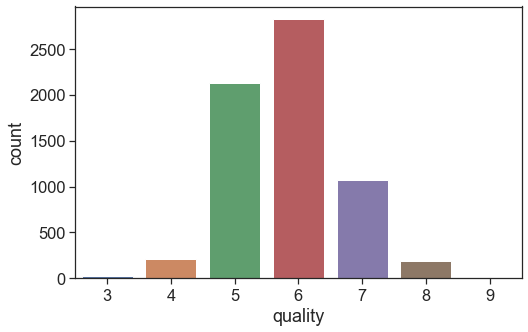

In [390]:
plt.figure(figsize=(8,5))

sns.countplot(x = 'quality', data = wines)
plt.show()

### 2.4.2 Проверка на корреляции по типам вин

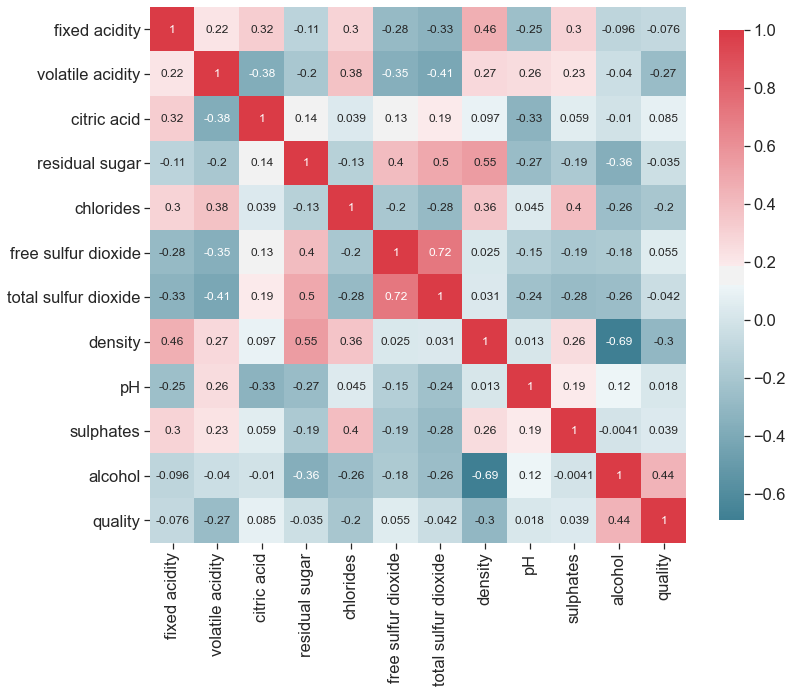

In [352]:
plot_correlation_map( wines )

### 2.4.3 Проверка на связь качества вина с содержанием  алкоголя

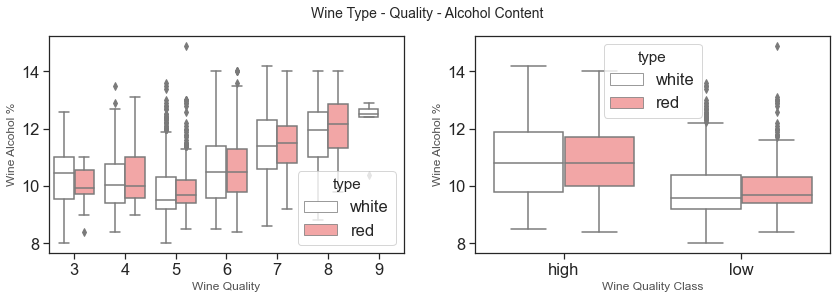

In [353]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Wine Type - Quality - Alcohol Content', fontsize=14)

sns.boxplot(x='quality', y='alcohol', hue='type', data=wines, palette={"red": "#FF9999", "white": "white"}, ax=ax1)
ax1.set_xlabel("Wine Quality",size = 12,alpha=0.8)
ax1.set_ylabel("Wine Alcohol %",size = 12,alpha=0.8)

sns.boxplot(x='quality_label', y='alcohol', hue='type', data=wines, palette={"red": "#FF9999", "white": "white"}, ax=ax2)
ax2.set_xlabel("Wine Quality Class",size = 12,alpha=0.8)
ax2.set_ylabel("Wine Alcohol %",size = 12,alpha=0.8)
plt.show()

На каждом приведенном выше графике изображено распределение уровня алкоголя для определенного качества вина, разделенного по типам. Мы можем четко наблюдать, что спирт по объемному распределению имеет тенденцию к увеличению для более качественных образцов вина, а некоторые выбросы на каждом уровне качества изображаются отдельными точками.

### 2.4.4 Проверка на связь между типами вина, качеством и кислотностью

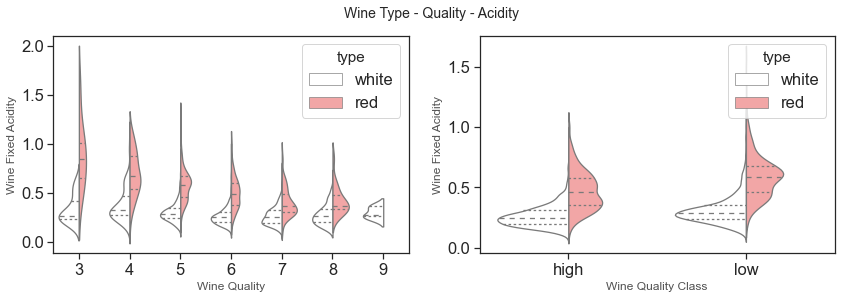

In [354]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
f.suptitle('Wine Type - Quality - Acidity', fontsize=14)

sns.violinplot(x='quality', y='volatile acidity', hue='type', data=wines, split=True, inner='quart', linewidth=1.3,
               palette={'red': '#FF9999', 'white': 'white'}, ax=ax1)
ax1.set_xlabel("Wine Quality",size = 12,alpha=0.8)
ax1.set_ylabel("Wine Fixed Acidity",size = 12,alpha=0.8)

sns.violinplot(x='quality_label', y='volatile acidity', hue='type', data=wines, split=True, inner='quart', linewidth=1.3,
               palette={'red': '#FF9999', 'white': 'white'}, ax=ax2)
ax2.set_xlabel("Wine Quality Class",size = 12,alpha=0.8)
ax2.set_ylabel("Wine Fixed Acidity",size = 12,alpha=0.8)
plt.show()

Совершенно очевидно, что образцы красного вина имеют более высокую кислотность по сравнению с аналогами из белого вина. Также мы можем наблюдать общее снижение кислотности с более высоким качеством для образцов красного вина, но не так сильно для образцов белого вина.

### 2.4.5 Проверка на связь между содержанием сульфатов и качеством

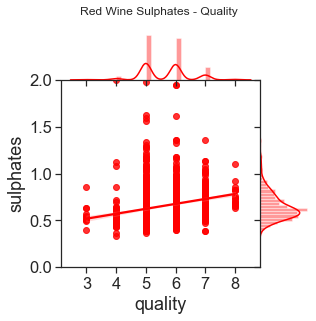

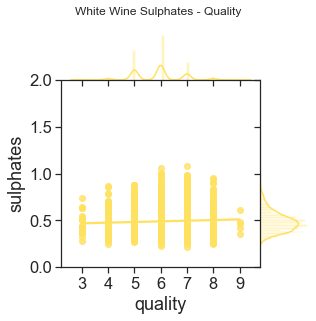

In [355]:
r = sns.jointplot(x='quality', y='sulphates', data=wines[wines.type == 'red'], # , ax = ax
                  kind='reg', ylim=(0, 2), color='red', space=0, size=4.5, ratio=4)
r.ax_joint.set_xticks(list(range(3,9)))
rfig = r.fig 
rfig.subplots_adjust(top=0.9)
t = rfig.suptitle('Red Wine Sulphates - Quality', fontsize=12)

w = sns.jointplot(x='quality', y='sulphates', data=wines[wines.type == 'white'],
                   kind='reg', ylim=(0, 2), color='#FFE160', space=0, size=4.5, ratio=4)
w.ax_joint.set_xticks(list(range(3,10)))
wfig = w.fig 
wfig.subplots_adjust(top=0.9)
t = wfig.suptitle('White Wine Sulphates - Quality', fontsize=12)

Несмотря на то, что, по-видимому, существует некоторая тенденция к более высокому уровню сульфатов для образцов вина более высокого качества, корреляция довольно слабая. 
Тем не менее, мы видим, что эта склонность вызвана более высокой концентрацией при среднем качестве, и определенно видим, что уровни сульфата для красного вина намного выше, чем в белом.

### 2.4.6 Проверка на связь между содержанием спирта, кислотностью и качеством

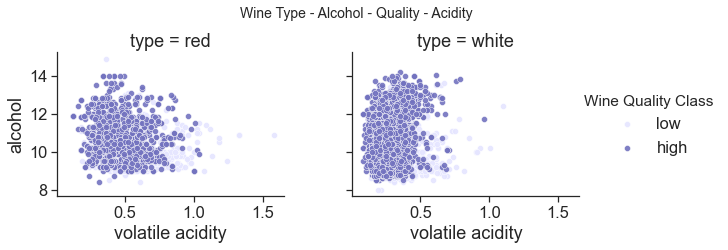

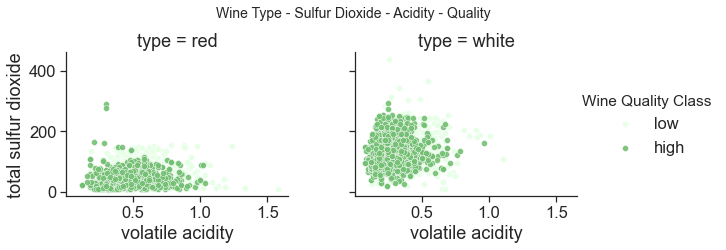

In [356]:
g = sns.FacetGrid(wines, col='type', hue='quality_label', col_order=['red', 'white'], hue_order=['low', 'high'],
                  aspect=1.2, size=3.5, palette=sns.light_palette('navy', 3))
g.map(plt.scatter, 'volatile acidity', 'alcohol', alpha=0.9, edgecolor='white', linewidth=0.5)
fig = g.fig
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Wine Type - Alcohol - Quality - Acidity', fontsize=14)
l = g.add_legend(title='Wine Quality Class')

g = sns.FacetGrid(wines, col='type', hue='quality_label', col_order=['red', 'white'], hue_order=['low', 'high'],
                  aspect=1.2, size=3.5, palette=sns.light_palette('green', 3))
g.map(plt.scatter, "volatile acidity", "total sulfur dioxide", alpha=0.9, edgecolor='white', linewidth=0.5)
fig = g.fig 
fig.subplots_adjust(top=0.8, wspace=0.3)
fig.suptitle('Wine Type - Sulfur Dioxide - Acidity - Quality', fontsize=14)
l = g.add_legend(title='Wine Quality Class')

Из первой пары графиков видно, что образцы вина высокого качества имеют более низкий уровень летучей кислотности и более высокий уровень содержания спирта по сравнению с образцами вина со средним и низким качеством. Помимо этого, мы также видим, что уровни летучей кислотности в образцах белого вина несколько ниже, чем в образцах красного вина.
   
На второй паре графиков летучая кислотность, а также общий диоксид серы значительно ниже в высококачественных образцах вина. Кроме того, общий объем диоксида серы значительно больше в образцах белого вина по сравнению с образцами красного вина. Однако уровни летучей кислотности в образцах белого вина несколько ниже, чем в образцах красного вина, которые мы также наблюдали на предыдущем графике.

# 3. Data Preparation

## 3.1 Приводим числовые переменные к нормальному распределению.
Используя преобразования бокса-кокса, приводим числовые пременные с наибольшим отклонением от нормального распределения к нормальному.

In [357]:
numeric_features = list(wines.dtypes[(wines.dtypes != "str") & (wines.dtypes !='object')].index)

skewed_features = wines[numeric_features].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness = pd.DataFrame({'Skew' :skewed_features})   

# Get only higest skewed features
skewness = skewness[abs(skewness) > 0.7]
skewness = skewness.dropna()
print ("There are {} higest skewed numerical features to box cox transform".format(skewness.shape[0]))

l_opt = {}

for feat in skewness.index:
    wines[feat], l_opt[feat] = boxcox((wines[feat]+1))

skewed_features2 = wines[skewness.index].apply(lambda x : skew (x.dropna())).sort_values(ascending=False)

#compute skewness
skewness2 = pd.DataFrame({'New Skew' :skewed_features2})   
display(pd.concat([skewness, skewness2], axis=1).sort_values(by=['Skew'], ascending=False))

There are 6 higest skewed numerical features to box cox transform


,Skew,New Skew
chlorides,5.402178,0.188542
sulphates,1.802523,0.010381
fixed acidity,1.721248,-0.062754
volatile acidity,1.499692,0.113617
residual sugar,1.436792,0.136151
free sulfur dioxide,1.223143,-0.036825


## 3.2 Проверяем переменные на мультиколинеарность
Используем для этого Variance Inflation Factor

In [358]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

class_ql = {'low':0, 'medium': 1, 'high': 2}
y_ql = wines.quality_label.map(class_ql)

def VRF(predict, data, y):
   
    scale = StandardScaler(with_std=False)
    df = pd.DataFrame(scale.fit_transform(data), columns= cols)
    features = "+".join(cols)
    df['quality_label'] = y.values

    # get y and X dataframes based on this regression:
    y, X = dmatrices(predict + ' ~' + features, data = df, return_type='dataframe')

   # Calculate VIF Factors
    # For each X, calculate VIF and save in dataframe
    vif = pd.DataFrame()
    vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns

    # Inspect VIF Factors
    display(vif.sort_values('VIF Factor'))
    return vif

cols = wines.columns.str.replace(' ', '_')
df = wines.copy()
df.columns = cols
# Remove the not applied to the qualty classification task
cols = list(cols.drop(['type', 'quality_label', 'quality']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)

,VIF Factor,features
0,1.000000,Intercept
10,1.407624,sulphates
3,1.441603,citric_acid
2,1.626372,volatile_acidity
9,1.887101,pH
5,2.234609,chlorides
6,2.418235,free_sulfur_dioxide
1,2.691677,fixed_acidity
7,3.061286,total_sulfur_dioxide
11,3.468885,alcohol


Удалим переменные residual sugar и total_sulfur_dioxide

In [359]:
cols = wines.columns.str.replace(' ', '_')
df = wines.copy()
df.columns = cols
# Remove the higest correlations and run a multiple regression
cols = list(cols.drop(['type', 'quality_label', 'quality', 'residual_sugar', 'total_sulfur_dioxide']))

vif = VRF('quality_label', df.loc[:, cols], y_ql)

del df, vif

,VIF Factor,features
0,1.000000,Intercept
8,1.328857,sulphates
5,1.386638,free_sulfur_dioxide
3,1.398013,citric_acid
7,1.524345,pH
2,1.618679,volatile_acidity
4,2.000589,chlorides
1,2.047872,fixed_acidity
9,2.530175,alcohol
6,3.259792,density


## 3.3 Приводим все переменные к числовому формату

In [360]:
wines.type = wines.type.map({'white':0, 'red':1})
wines.quality_label = wines.quality_label.map({'low':0,'high':1})

## 3.4 Сборка финальных датасетов для моделирования

In [361]:
details = rstr(wines, 'quality')
details.sort_values(by='missing_ration', ascending=False)

Data shape: (6463, 14)
___________________________
Data types:
 float64    11
int64       3
Name: types, dtype: int64
___________________________


,types,counts,distincts,nulls,missing_ration,uniques,skewness,kurtosis,corr quality
type,int64,6463,2,0,0.0,"[[0.0, 1.0]]",1.176806,-0.615318,-0.119185
fixed acidity,float64,6463,106,0,0.0,"[[0.592320099547976, 0.5907042481639728, 0.598...",-0.062769,1.078943,-0.096198
volatile acidity,float64,6463,187,0,0.0,"[[0.15788839712151287, 0.2400355193154612, 0.1...",0.113643,-0.571036,-0.257907
citric acid,float64,6463,89,0,0.0,"[[0.42, 0.06, 0.24, 0.4, 0.41, 0.39, 0.37, 0.2...",0.474907,2.416930,0.084926
residual sugar,float64,6463,315,0,0.0,"[[1.6112213856588111, 0.8967329740259065, 1.00...",0.136183,-1.352470,-0.006633
chlorides,float64,6463,214,0,0.0,"[[0.02573403298859264, 0.03216036051403282, 0....",0.188585,-0.289483,-0.279084
free sulfur dioxide,float64,6463,135,0,0.0,"[[10.303762169335236, 4.716104447601934, 5.166...",-0.036834,-0.129799,0.090845
total sulfur dioxide,float64,6463,276,0,0.0,"[[173.0, 31.0, 44.0, 10.0, 153.0, 7.0, 105.0, ...",-0.000425,-0.369688,-0.041598
density,float64,6463,996,0,0.0,"[[0.9994, 0.9948, 0.998, 0.99536, 0.9966, 0.99...",0.504204,6.614623,-0.304447
pH,float64,6463,108,0,0.0,"[[3.28, 3.51, 3.12, 3.31, 3.27, 3.19, 3.05, 3....",0.391094,0.378444,0.018403


In [362]:
# X = wines[['type', 'alcohol', 'density', 'volatile acidity', 'chlorides',
#        'citric acid', 'fixed acidity', 'free sulfur dioxide',
#        'total sulfur dioxide', 'sulphates', 'residual sugar', 'pH']] 

X = wines[['type', 'alcohol', 'density', 'volatile acidity', 'chlorides',
       'citric acid', 'fixed acidity', 'free sulfur dioxide',
       'sulphates', 'pH']] 

y = wines.quality_label

X_train, X_valid, y_train, y_valid = train_test_split(X,y, test_size=0.2, random_state=40)

print (X.shape , y_train.shape , X_train.shape , y_valid.shape , X_valid.shape)

(6463, 10) (5170,) (5170, 10) (1293,) (1293, 10)


# 4. Моделирование
Теперь мы выберем модель, которую хотели бы попробовать. Используем обучающий набор данных для обучения модели и затем проверим ее с помощью тестового набора.

## 4.1 Выбор модели
### 4.1.1 Logistic regression

In [363]:
lr = LogisticRegression(random_state=40)
lr.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=40, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [364]:
lr_train_accuracy = lr.score(X_train, y_train)
lr_valid_accuracy = lr.score(X_valid, y_valid)
print(
      'Accuracy Score of Train Model : {:.2f}'.format(lr_train_accuracy), 
      'Accuracy Score of Valid  Model : {:.2f}'.format(lr_valid_accuracy), sep='\n')

Accuracy Score of Train Model : 0.72
Accuracy Score of Valid  Model : 0.71


Посмотрим на метрики качества предсказания на валидационной выборке

In [368]:
pred = lr.predict(X_valid)
print('accuracy:',accuracy_score(y_valid,pred))
print('precision:',precision_score(y_valid,pred,average='binary'))
print('recall:',recall_score(y_valid,pred,average='binary'))
print('f:',f1_score(y_valid,pred,average='binary'))

accuracy: 0.711523588553751
precision: 0.7446327683615819
recall: 0.8176178660049628
f: 0.7794204612655233


Посмотрим на confusion matrix

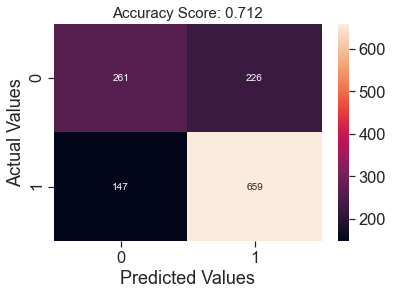

In [369]:
predictions = pred
score = round(accuracy_score(y_valid, predictions), 3)
cm1 = cm(y_valid, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

### 4.1.2 K-Nearest Neighbor classifier
Повторим все шаги для этой модели

In [393]:
k_range = range(5,15)
l_range = range(10,20)
weights_options=['uniform','distance']

param = {'n_neighbors':k_range, 'weights':weights_options, 'leaf_size':l_range}

cv = StratifiedShuffleSplit(n_splits=30, test_size=.30, random_state=15)
 
grid_KN = GridSearchCV(KNeighborsClassifier(), param,cv=cv,verbose = False, n_jobs=-1)

grid_KN = grid_KN.fit(X_train,y_train).best_estimator_

In [394]:
grid_KN

KNeighborsClassifier(algorithm='auto', leaf_size=10, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                     weights='distance')

In [395]:
dt_train_accuracy = grid_KN.score(X_train, y_train)
dt_test_accuracy = grid_KN.score(X_valid, y_valid)
print( 
      'Accuracy in Train Group   : {:.2f}'.format(dt_train_accuracy), 
      'Accuracy in Validation  Group   : {:.2f}'.format(dt_test_accuracy), sep='\n')

Accuracy in Train Group   : 1.00
Accuracy in Validation  Group   : 0.79


In [396]:
pred = grid_KN.predict(X_valid)
print('accuracy:',accuracy_score(y_valid,pred))
print('precision:',precision_score(y_valid,pred,average='binary'))
print('recall:',recall_score(y_valid,pred,average='binary'))
print('f:',f1_score(y_valid,pred,average='binary'))

accuracy: 0.7873163186388245
precision: 0.8076477404403245
recall: 0.8647642679900744
f: 0.8352306770521271


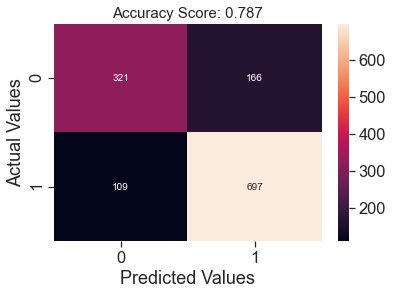

In [397]:
predictions = pred
score = round(accuracy_score(y_valid, predictions), 3)
cm1 = cm(y_valid, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

### 4.1.3 Decision Tree Classifier
Повторим все шаги для этой модели

In [398]:
max_depth = range(1,10)
max_feature = ['auto']
criterion=["entropy", "gini"]

param = {'max_depth':max_depth, 
         'max_features':max_feature, 
         'criterion': criterion}
grid_DT = GridSearchCV(DecisionTreeClassifier(), 
                                param_grid = param,
                                 cv=StratifiedShuffleSplit(n_splits=10, test_size=.30, random_state=15),
                                n_jobs = -1)
grid_DT = grid_DT.fit(X_train, y_train).best_estimator_

In [399]:
pred = grid_DT.predict(X_valid)

In [400]:
dt_train_accuracy = grid_DT.score(X_train, y_train)
dt_test_accuracy = grid_DT.score(X_valid, y_valid)
print(
      'Accuracy in Train Group   : {:.2f}'.format(dt_train_accuracy), 
      'Accuracy in Validation  Group   : {:.2f}'.format(dt_test_accuracy), sep='\n')

Accuracy in Train Group   : 0.78
Accuracy in Validation  Group   : 0.74


In [401]:
print('accuracy:',accuracy_score(y_valid,pred))
print('precision:',precision_score(y_valid,pred,average='binary'))
print('recall:',recall_score(y_valid,pred,average='binary'))
print('f:',f1_score(y_valid,pred,average='binary'))

accuracy: 0.7409126063418406
precision: 0.776084407971864
recall: 0.8213399503722084
f: 0.7980711271850511


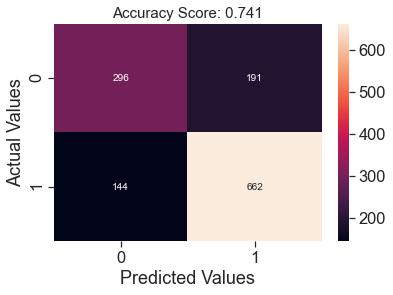

In [402]:
predictions = pred
score = round(accuracy_score(y_valid, predictions), 3)
cm1 = cm(y_valid, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

## 4.2 Выбор лучшей модели

Мы рассмотрели три классификатора на наших данных : Логистическая регрессия, к ближайших соседей и дерево решений. Все три  модели на валидации дают достаточно высокую точность. При сравнении метрики качества на валидационной выборке в моделях леса и регрессии уступают модели "к ближайших соседей". Поэтому из этих трех моделей мы выбираем модель "к ближайших соседей". Результат достаточно неожиданный, так как по опыту немного где данная модель проявляет себя лучше, чем регрессия и дерево решений.

In [403]:
final_model = grid_KN

# 5. Оценка

In [404]:
pred = final_model.predict(X_valid)
print('accuracy:',accuracy_score(y_valid,pred))
print('precision:',precision_score(y_valid,pred,average='weighted'))
print('recall:',recall_score(y_valid,pred,average='weighted'))
print('f:',f1_score(y_valid,pred,average='weighted'))

accuracy: 0.7873163186388245
precision: 0.7846212231907186
recall: 0.7873163186388245
f: 0.7843379997407238


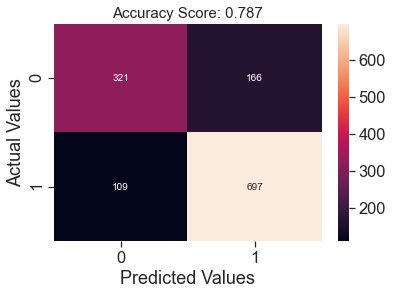

In [405]:
predictions = final_model.predict(X_valid)
score = round(accuracy_score(y_valid, predictions), 3)
cm1 = cm(y_valid, predictions)
sns.heatmap(cm1, annot=True, fmt=".0f")
plt.xlabel('Predicted Values')
plt.ylabel('Actual Values')
plt.title('Accuracy Score: {0}'.format(score), size = 15)
plt.show()

# 6. Развертывание

В данном случае этот раздел не нужен, потому что задача носит сугубо исследовательский характер и работу можно окончить на этапе оценки модели.